In [5]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import statistics
col_width = 7.141
plt.style.use(['./figures.mplstyle'])

# Reading Data

In [27]:
minutes = [5]
devices = list(range(100, 1260000, 100)) + [350]
bitlistIntervals = [2000, 10000]
moves = [False]
uniforms = [True]
broadcastTypes = ['smart', 'simple']
spacings = [2, 3, 5, 7, 10, 15]
rates = [30000, 60000, 120000]

data = {}
for minute in minutes:
    for device in devices:
        for bitlist in bitlistIntervals:
            for move in moves:
                for uniform in uniforms:
                    for broadcastType in broadcastTypes:
                        for space in spacings:
                            for rate in rates:
                                file_name = 'minutes_{minutes}_numDevices_{num_devices}_bitListInterval_{bitlist}_move_{move}_uniform_{uniform}_broadcastType_{broadcastType}_uniformSpacing_{space}_sendRate_{rate}.csv'.format(
                                    space=space, 
                                    num_devices=device, 
                                    minutes=minute, 
                                    bitlist=bitlist, 
                                    move=move, 
                                    uniform=uniform,
                                    broadcastType=broadcastType,
                                    rate=rate)
                                try:
                                    data[(minute, device, bitlist, move, uniform, broadcastType, space, rate)] = pd.read_csv('./summaries/' + file_name)
                                except Exception as e:
                                    # no data for this combo
                                    continue


# Graphing Functions

In [29]:
def get_cdf(df, col):
    sorted_data = np.sort(df[col])
    sorted_data_cdf = np.arange(len(sorted_data))/float(len(sorted_data)) * 100
    
    return sorted_data, sorted_data_cdf

def bandwidth_cdf(data, params):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('Mb/s')
    ax.set_ylabel('% Data')
#     ax.set_title('Bandwidth CDF')ß
    
    for device in params['devices']:
        xs, ys = get_cdf(data[(params['minute'], 
                             device, 
                             params['bitlist'], 
                             params['move'], 
                             params['uniform'],
                             params['broadcastType'],
                             params['space'], 
                             params['rate'])], 
                       'MB')
        # convert to Mb/s
        xs = [x * 8 for x in xs]
        label = '{device} Devices'.format(device=device)
        ax.plot(xs, ys, label=label)

    # add vertical line at 2 Mb/s
    plt.axvline(x = 1.4, color = 'black', linestyle='--')
    
    ax.legend()
    
    name = 'bandwidth_minutes_{minutes}_bitListInterval_{bitlist}_move_{move}_uniform_{uniform}_broadcastType_{broadcastType}_uniformSpacing_{space}_sendRate_{rate}.pdf'.format( 
                space=params['space'],                        
                minutes=params['minute'], 
                bitlist=params['bitlist'], 
                move=params['move'], 
                uniform=params['uniform'], 
                broadcastType=params['broadcastType'],
                rate=params['rate'])
    
    plt.savefig('./Figures/bandwidths/' + name, bbox_inches = 'tight',
    pad_inches = 0.1, format='pdf')
    
    plt.show()

In [8]:
def avg_device_quantile(df, q):
    num_devices = len(df['Device'].unique())
    # find qth quantile for each device
    quantiles = [total_quantile(df[df['Device'] == dev_id], q) for dev_id in range(num_devices)]
    return sum(quantiles) / num_devices

def med_device_quantile(df, q):
    num_devices = len(df['Device'].unique())
    # find qth quantile for each device
    quantiles = [total_quantile(df[df['Device'] == dev_id], q) for dev_id in range(num_devices)]
    return statistics.median(quantiles)

def total_quantile(df, q):
    return df['MB'].quantile(q)

def capacity_line(data, params, q, measure, threshold):
    bws = {}
    
    # get all bandwidths
    for space, devices in params['spacings'].items():
        for device in devices:
            df = data[(params['minute'], device, params['bitlist'], params['move'], params['uniform'], params['broadcastType'], space, params['rate'])]
            bws[(device, space)] = measure(df, q)
           
    # find capacities (largest bw < 0.25 that we see)
    capacities = {}
    for space in params['spacings']:
        capacities[space] = 0
        
    for space, devices in params['spacings'].items():
        for device in devices:
            if (capacities[space] < device) and (bws[(device, space)] <= threshold):
                capacities[space] = device
                  
    display(capacities)
    xs, ys = zip(*capacities.items())
    
    return xs, ys

def capacities(data, params, qs, measure, threshold):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('Spacing (ft. apart)')
    ax.set_ylabel('Number of Devices')
#     ax.set_title('Capacities')
    
    for q in qs:
        xs, ys = capacity_line(data, params, q, measure, threshold)
        print(xs, ys)
        ax.plot(xs, ys, marker='o', label='{percentile:0.0f}th percentile'.format(percentile=q*100))
    
    plt.legend()
    
    name = 'capacity_minutes_{minutes}_bitListInterval_{bitlist}_move_{move}_uniform_{uniform}_broadcastType_{broadcastType}_sendRate_{rate}.pdf'.format( 
                                minutes=params['minute'], 
                                bitlist=params['bitlist'], 
                                move=params['move'], 
                                uniform=params['uniform'], 
                                broadcastType=params['broadcastType'],
                                rate=params['rate'])
    
    plt.savefig('./Figures/capacity/' + name, bbox_inches = 'tight',
    pad_inches = 0.1, format='pdf')
    
    plt.show()
    
    return xs, ys


# Smart Broadcasting

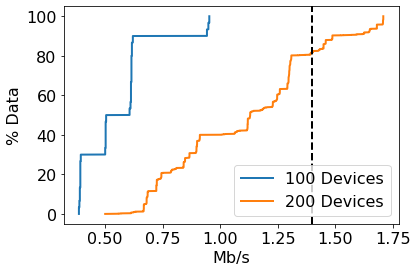

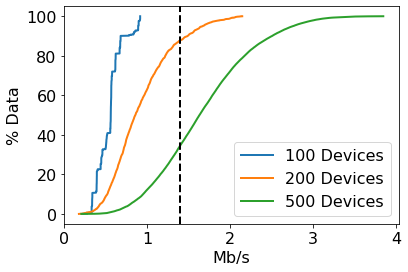

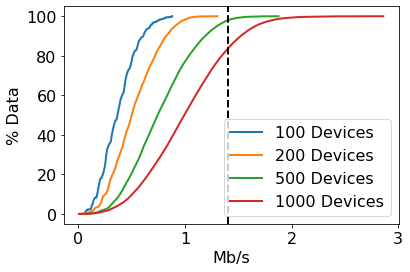

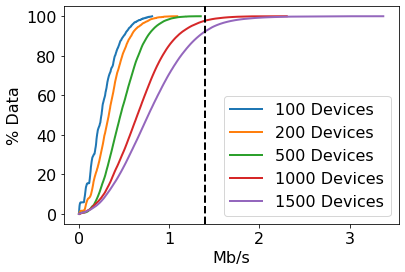

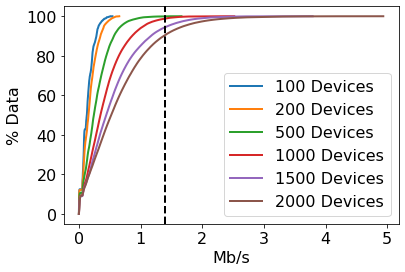

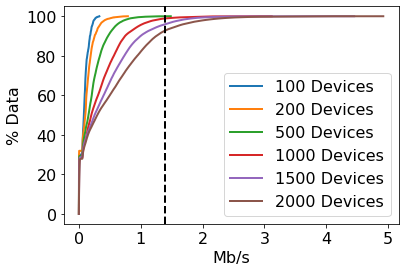

In [30]:
bandwidth_cdf(data, {'space': 2, 
                     'minute': 5, 
                     'bitlist': 10000, 
                     'move': False, 
                     'uniform': True, 
                     'broadcastType': 'smart',
                     'rate': 30000,
                     'devices': [100, 200]})

bandwidth_cdf(data, {'space': 3, 
                     'minute': 5, 
                     'bitlist': 10000, 
                     'move': False, 
                     'uniform': True, 
                     'broadcastType': 'smart',
                     'rate': 30000,
                     'devices': [100, 200, 500]})

bandwidth_cdf(data, {'space': 5, 
                     'minute': 5, 
                     'bitlist': 10000, 
                     'move': False, 
                     'uniform': True, 
                     'broadcastType': 'smart',
                     'rate': 30000,
                     'devices': [100, 200, 500, 1000]})

bandwidth_cdf(data, {'space': 7, 
                     'minute': 5, 
                     'bitlist': 10000, 
                     'move': False, 
                     'uniform': True, 
                     'broadcastType': 'smart',
                     'rate': 30000,
                     'devices': [100, 200, 500, 1000, 1500]})

bandwidth_cdf(data, {'space': 10, 
                     'minute': 5, 
                     'bitlist': 10000, 
                     'move': False, 
                     'uniform': True,
                     'broadcastType': 'smart',
                     'rate': 30000,
                     'devices': [100, 200, 500, 1000, 1500, 2000]})

bandwidth_cdf(data, {'space': 15, 
                     'minute': 5, 
                     'bitlist': 10000, 
                     'move': False, 
                     'uniform': True, 
                     'broadcastType': 'smart',
                     'rate': 30000,
                     'devices': [100, 200, 500, 1000, 1500, 2000]})

In [10]:
# data[(5, 200, 10000, False, True, 'smart', 5, 30000)]
for m, d, t, mov, u, b, s, r in data.keys():
    if s == 15 and b == 'smart' and r == 30000 and t == 10000:
        print((m, d, t, mov, u, b, s, r))

(5, 100, 10000, False, True, 'smart', 15, 30000)
(5, 200, 10000, False, True, 'smart', 15, 30000)
(5, 300, 10000, False, True, 'smart', 15, 30000)
(5, 400, 10000, False, True, 'smart', 15, 30000)
(5, 500, 10000, False, True, 'smart', 15, 30000)
(5, 600, 10000, False, True, 'smart', 15, 30000)
(5, 700, 10000, False, True, 'smart', 15, 30000)
(5, 800, 10000, False, True, 'smart', 15, 30000)
(5, 900, 10000, False, True, 'smart', 15, 30000)
(5, 1000, 10000, False, True, 'smart', 15, 30000)
(5, 1100, 10000, False, True, 'smart', 15, 30000)
(5, 1200, 10000, False, True, 'smart', 15, 30000)
(5, 1300, 10000, False, True, 'smart', 15, 30000)
(5, 1400, 10000, False, True, 'smart', 15, 30000)
(5, 1500, 10000, False, True, 'smart', 15, 30000)
(5, 1600, 10000, False, True, 'smart', 15, 30000)
(5, 1700, 10000, False, True, 'smart', 15, 30000)
(5, 1800, 10000, False, True, 'smart', 15, 30000)
(5, 1900, 10000, False, True, 'smart', 15, 30000)
(5, 2000, 10000, False, True, 'smart', 15, 30000)
(5, 2100,

## 30 Seconds - Add 15 @ 2000

{2: 100, 3: 200, 5: 900, 7: 1900, 10: 2700, 15: 2800}

(2, 3, 5, 7, 10, 15) (100, 200, 900, 1900, 2700, 2800)


{2: 100, 3: 100, 5: 800, 7: 1700, 10: 2200, 15: 2300}

(2, 3, 5, 7, 10, 15) (100, 100, 800, 1700, 2200, 2300)


{2: 100, 3: 100, 5: 600, 7: 1100, 10: 1600, 15: 1600}

(2, 3, 5, 7, 10, 15) (100, 100, 600, 1100, 1600, 1600)


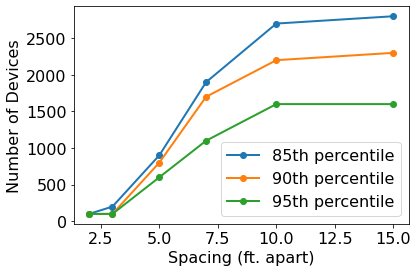

((2, 3, 5, 7, 10, 15), (100, 100, 600, 1100, 1600, 1600))

In [11]:
space_device_mappings = {2: list(range(100, 300, 100)), # done
                         3: list(range(100, 400, 100)), # done
                         5: list(range(600, 1200, 100)), # done
                         7: list(range(1100, 2100, 100)), # done
                         10: list(range(1400, 3100, 100)), # done
                         15: list(range(1400, 3100, 100))} # done

params = {'minute': 5, 
          'bitlist': 10000, 
          'move': False,
          'uniform': True,
          'broadcastType': 'smart',
          'rate': 30000,
          'spacings': space_device_mappings}


capacities(data, params, [0.85, 0.9, 0.95], total_quantile, 0.175)
# capacities(data, params, [0.9, 0.95], med_device_quantile)
# capacities(data, params, [0.9, 0.95], avg_device_quantile)

## 1 Minute

{2: 200, 3: 200, 5: 1900, 7: 3900, 10: 5200, 15: 6200}

(2, 3, 5, 7, 10, 15) (200, 200, 1900, 3900, 5200, 6200)


{2: 100, 3: 200, 5: 1400, 7: 3300, 10: 4300, 15: 4700}

(2, 3, 5, 7, 10, 15) (100, 200, 1400, 3300, 4300, 4700)


{2: 100, 3: 200, 5: 1200, 7: 2500, 10: 3100, 15: 3300}

(2, 3, 5, 7, 10, 15) (100, 200, 1200, 2500, 3100, 3300)


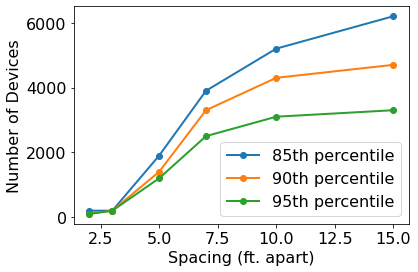

((2, 3, 5, 7, 10, 15), (100, 200, 1200, 2500, 3100, 3300))

In [12]:
space_device_mappings = {2: list(range(100, 400, 100)), # done
                         3: list(range(100, 400, 100)), # done
                         5: list(range(1000, 2400, 100)), # done
                         7: list(range(1900, 4200, 100)), # done
                         10: list(range(3000, 5600, 100)), # done
                         15: list(range(3200, 3700, 100)) + list(range(4000, 6400, 100))} # done

params = {'minute': 5, 
          'bitlist': 10000, 
          'move': False,
          'uniform': True,
          'broadcastType': 'smart',
          'rate': 60000,
          'spacings': space_device_mappings}


capacities(data, params, [0.85, 0.9, 0.95], total_quantile, 0.175)

## 2 min

{2: 200, 3: 200, 5: 2400, 7: 4700, 10: 8100, 15: 12300}

(2, 3, 5, 7, 10, 15) (200, 200, 2400, 4700, 8100, 12300)


{2: 200, 3: 200, 5: 1900, 7: 3900, 10: 5800, 15: 9600}

(2, 3, 5, 7, 10, 15) (200, 200, 1900, 3900, 5800, 9600)


{2: 200, 3: 100, 5: 1300, 7: 2900, 10: 3800, 15: 6200}

(2, 3, 5, 7, 10, 15) (200, 100, 1300, 2900, 3800, 6200)


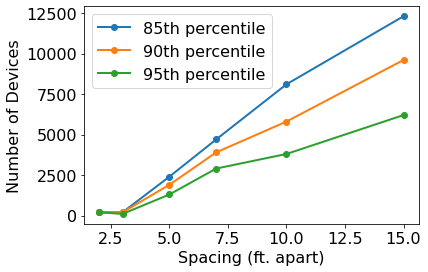

((2, 3, 5, 7, 10, 15), (200, 100, 1300, 2900, 3800, 6200))

In [28]:
space_device_mappings = {2: list(range(100, 500, 100)), # done
                         3: list(range(100, 500, 100)), # done
                         5: list(range(100, 2600, 100)), # done
                         7: list(range(100, 4900, 100)), # done
                         10: list(range(100, 8300, 100)), # done
                         15: list(range(100, 12500, 100))} # done

params = {'minute': 5, 
          'bitlist': 10000, 
          'move': False,
          'uniform': True,
          'broadcastType': 'smart',
          'rate': 120000,
          'spacings': space_device_mappings}


capacities(data, params, [0.85, 0.9, 0.95], total_quantile, 0.175)

burstiness is a problem. if we added queues and limited sending to 2 Mb / 10 per 100ms, how would this change things?




**Does the amount of traffic continue to increase as more messages are sent or does it level off? - need to run for > 5 min** - time series of total network volume

show that traffic is less at the start of simulation than at the end

# Simple Broadcasting

{2: 100, 3: 100, 5: 100, 7: 300, 10: 600, 15: 2400}

(2, 3, 5, 7, 10, 15) (100, 100, 100, 300, 600, 2400)


{2: 100, 3: 100, 5: 100, 7: 200, 10: 600, 15: 2300}

(2, 3, 5, 7, 10, 15) (100, 100, 100, 200, 600, 2300)


{2: 100, 3: 100, 5: 100, 7: 200, 10: 600, 15: 2100}

(2, 3, 5, 7, 10, 15) (100, 100, 100, 200, 600, 2100)


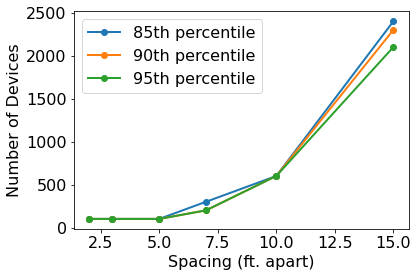

((2, 3, 5, 7, 10, 15), (100, 100, 100, 200, 600, 2100))

In [14]:
space_device_mappings = {2: list(range(100, 400, 100)),  # done
                         3: list(range(100, 400, 100)), # done
                         5: list(range(100, 1000, 100)), # done
                         7: list(range(100, 1000, 100)), # done
                         10: list(range(100, 1600, 100)), # done
                         15: list(range(100, 2600, 100))} # done
params = {'minute': 5, 
          'bitlist': 10000, 
          'move': False,
          'uniform': True,
          'broadcastType': 'simple',
          'rate': 30000,
          'spacings': space_device_mappings}


capacities(data, params, [0.85, 0.9, 0.95], total_quantile, 0.175)

## Simple vs Smart

In [59]:
def capacity_line_compare(data, params, q, measure, threshold):
    bws = {}
    
    # get all bandwidths
    for space, devices in params['spacings'].items():
        for device in devices:
            try:
                df = data[(params['minute'], device, params['bitlist'], params['move'], params['uniform'], params['broadcastType'], space, params['rate'])]
                bws[(device, space)] = measure(df, q)
            except:
                bws[(device, space)] = 10000000000000 # too high of a number
           
    # find capacities (largest bw < 0.25 that we see)
    capacities = {}
    for space in params['spacings']:
        capacities[space] = 0
        
    for space, devices in params['spacings'].items():
        for device in devices:
            if (capacities[space] < device) and (bws[(device, space)] <= threshold):
                capacities[space] = device
                  
    display(capacities)
    xs, ys = zip(*capacities.items())
    
    return xs, ys

def capacities_compare(data, params, broadcastTypes, q, measure, threshold):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('Spacing (ft. apart)')
    ax.set_ylabel('Number of Devices')
#     ax.set_title('Capacities')
    
    for broadcastType in broadcastTypes:
        params['broadcastType'] = broadcastType
        xs, ys = capacity_line_compare(data, params, q, measure, threshold)
        print(xs, ys)
        ax.plot(xs, ys, marker='o', label='{0}'.format(broadcastType))
    
    ###
#     x1 = data[5, 1600, 10000, False, True, 'smart', 10, 30000]
#     y1 = measure(x1, 0.95)
#     prop_cycle = plt.rcParams['axes.prop_cycle']
#     colors = prop_cycle.by_key()['color']
#     xs = [10, 15]
#     ys = [1600, 2600]
#     ax.plot(xs, ys, marker='o', color=colors[0], linestyle='--', label='variable DS rate'.format(broadcastType))
    ###
    plt.legend()
    
    name = 'capacity_comparison.pdf'
    
    plt.savefig('./Figures/capacity/' + name, bbox_inches = 'tight', pad_inches = 0.1, format='pdf')
    
    plt.show()
    
    return xs, ys

{2: 100, 3: 100, 5: 600, 7: 1100, 10: 1600, 15: 1600}

(2, 3, 5, 7, 10, 15) (100, 100, 600, 1100, 1600, 1600)


{2: 100, 3: 100, 5: 100, 7: 200, 10: 600, 15: 2100}

(2, 3, 5, 7, 10, 15) (100, 100, 100, 200, 600, 2100)


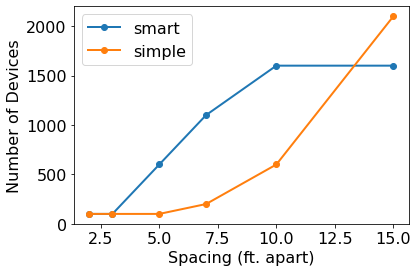

((2, 3, 5, 7, 10, 15), (100, 100, 100, 200, 600, 2100))

In [60]:
params = {'minute': 5, 
          'bitlist': 10000, 
          'move': False,
          'uniform': True,
          'rate': 30000,
          'spacings': space_device_mappings}


capacities_compare(data, params, ['smart', 'simple'], 0.95, total_quantile, 0.175)

{2: 0, 3: 0, 5: 0, 7: 0, 10: 0, 15: 2600}

(2, 3, 5, 7, 10, 15) (0, 0, 0, 0, 0, 2600)


{2: 0, 3: 0, 5: 0, 7: 0, 10: 0, 15: 0}

(2, 3, 5, 7, 10, 15) (0, 0, 0, 0, 0, 0)


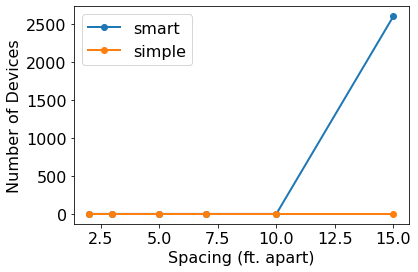

((2, 3, 5, 7, 10, 15), (0, 0, 0, 0, 0, 0))

In [38]:
params = {'minute': 5, 
          'bitlist': 2000, 
          'move': False,
          'uniform': True,
          'rate': 30000,
          'spacings': space_device_mappings}


capacities_compare(data, params, ['smart', 'simple'], 0.95, total_quantile, 0.175)